# Volume Weighted Average vs Simple Moving Average

We are developing a simple model to test if the volume weighted average price (VWAP) is a better indicator of future stock price than a simple moving average price (SMAP). Our hypothesis is that it is, since the VWAP contains more information (i.e. the volume of stocks traded) than the SMAP. Before developing the model, we first give some definitions.

For our purposes, we define the VWAP of stock $A$ as
$$\mathrm{VWAP}_{A}(d) = \frac{\sum_{t=-d}^{0} p_{A}(t)\times V_{A}(t)}{\sum_{t=-d}^{0} V_{A}(t)}$$
Here $p_{A}(d)$ and $V_{A}(d)$ are the closing price of stock $A$ and the volume of stock $A$ (number of shares) , respectively, traded $d$ market days ago. The variable $d$ thus serves as the anchoring point for the volume weighted average.

The SMAP of stock $A$ is defined as
$$\mathrm{SMAP}_{A}(d) = \frac{1}{d+1}\sum_{t=-d}^{0} p_{A}(t)$$
where $d$ is again the lookback period.

To test the model, we will analyze the stocks that constitute the MMI. Our data came from [kaggle](https://www.kaggle.com/borismarjanovic/price-volume-data-for-all-us-stocks-etfs).

### Reading in historical data
We will start by reading in the historical data for stocks in the NYSE ARCA Major Market Index

In [1]:
# Lets first import some useful libraries for data analysis
import numpy as np
import pandas as pd
from pandas.plotting import _converter
_converter.register()
import matplotlib.pyplot as plt
import matplotlib.dates  as dates

# Create a dictionary of stock ticker symbols
ARCAMMI_Stocks={'AmericanExpress':'axp',
                'Boeing':'ba',
                'Chevron':'cvx',
                'DowDupont':'dwdp',
                'Disney':'dis',
                'GeneralElectric':'ge',
                'HewlettPackard':'hpq',
                'IBM':'ibm',
                'JohnsonAndJohnson':'jnj',
                'JPMorgan':'jpm',
                'CocaCola':'ko',
                'McDonalds':'mcd',
                '3M':'mmm',
                'Merck':'mrk',
                'Microsoft':'msft',
                'ProcterAndGamble':'pg',
                'WellsFargo':'wfc',
                'Walmart':'wmt',
                'ExxonMobil':'xom'}

# Read in the historical data
historical_data = {}
for key, ticker in ARCAMMI_Stocks.items():
    historical_data[key] = pd.read_csv('MMI_DATA/'+ticker+'.txt',index_col=0)

We have access to the following data:
	 High
	 Low
	 Open
	 Close
	 Volume
	 Adj Close


Historical Closing Price for Disney Stock:


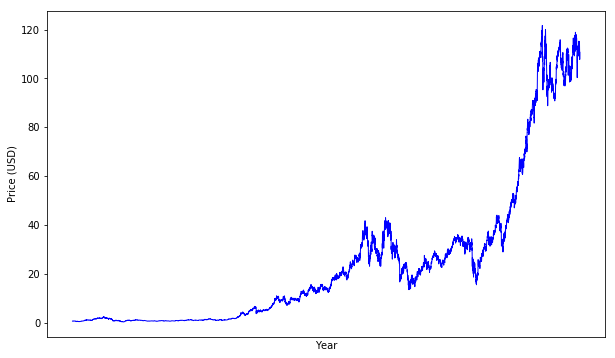

In [15]:
# Lets see what other data we have available to us
print('We have access to the following data:')
for col in historical_data['Disney'].columns.values:
    print('\t',col)


# Lets go ahead and take a look at Disney's historical closing price
print('\n\nHistorical Closing Price for Disney Stock:')
fig, ax = plt.subplots(1,1,figsize=(10,6))
ax.plot_date(historical_data['Disney'].index.values, historical_data['Disney']['Close'],
             color='blue',linewidth=1,marker='',linestyle='-')

#print dates.YearLocator()
ax.xaxis.set_major_locator(dates.YearLocator(base=5))
ax.set_xlabel('Year')
ax.set_ylabel('Price (USD)')
plt.show()
plt.close()


## VWAP and SMAP Functions

Now that we have got the stock data in, lets write some functions to calculate the VWAP and SMAP.

In our [`metrics`](metrics.py) module we've defined `calc_vwap(price, volume, period_lookback)` and `calc_smap(price, volume, period_lookback)`

## Generate VWAP and SMAP Data
Now that we have functions to calculate VWAP and SMAP, lets go ahead and generate the data using an anchor of 15 days and the stock closing price.

In [4]:
import metrics

lookback = 15
for company in historical_data:
    historical_data[company]['VWAP'] = metrics.calc_vwap(historical_data[company]['Close'],historical_data[company]['Volume'],lookback)
    historical_data[company]['SMAP'] = metrics.calc_smap(historical_data[company]['Close'],lookback)

/home/hofbr/GitProjects/VWAP_backtest/metrics.py:9: RuntimeWarning: invalid value encountered in double_scalars
  vwap[i] = (price[lb:ub] * volume[lb:ub]).sum() / volume[lb:ub].sum()


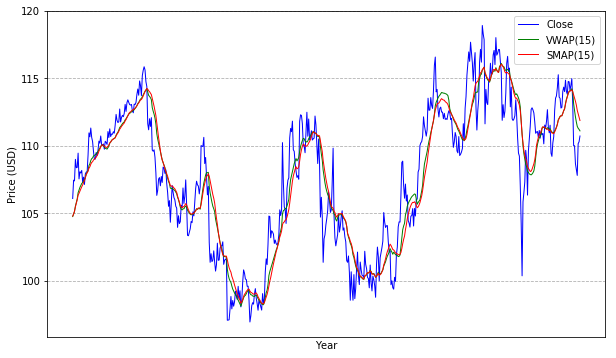

In [18]:
# Lets go ahead and take a look at the disney data from 2017 on
start = '2017-01-01'
fig, ax2 = plt.subplots(1,1,figsize=(10,6))

ax2.plot_date(historical_data['Disney'][start:].index.values, historical_data['Disney'][start::]['Close'],
             color='blue',linewidth=1,marker='',linestyle='-',label='Close')
ax2.plot_date(historical_data['Disney'][start:].index.values, historical_data['Disney'][start::]['VWAP'],
             color='green',linewidth=1,marker='',linestyle='-',label='VWAP('+str(lookback)+')')
ax2.plot_date(historical_data['Disney'][start:].index.values, historical_data['Disney'][start::]['SMAP'],
             color='red',linewidth=1,marker='',linestyle='-',label='SMAP('+str(lookback)+')')

ax2.xaxis.set_major_locator(dates.MonthLocator(interval=2))
ax2.xaxis.set_major_formatter(dates.DateFormatter("%b '%y"))
ax2.set_xlabel('Year')
ax2.set_ylabel('Price (USD)')
ax2.legend()
ax2.grid(linestyle='dashed')
plt.show()
plt.close()

## A Simple Strategy

We are going to implement a strategy based on the following principles:

1. When the price is above the SMAP or the VWAP, we are going to be in a long position.
2. When the price is below the SMAP or the VWAP, we are going to be in a cash position.

We want to run tests for diffent number of lookback days for calculating SMAP and VWAP to see if we can find an optimal value for outperforming the benchmark, which is just a buy and hold strategy, and to see if the number of lookback days affects the performance of VWAP vs SMAP.

Some questions we hope to answer:
1. What is the optimal number of lookback days
2. How many signals are different between VWAP and SMAP

In [19]:
# Here define some functions to calculate our signals and values 

# If the price is greater than VWAP or SMAP, we want to go long (1), otherwise we want to be in a cash position (0)
def set_signal(metric, price, lookback):
    signal = np.zeros(len(price))
    for i in range(len(price)):
        if price[i] > metric[i] and i >= lookback and i < len(price) - 1:
            signal[i + 1] = 1
            
    return signal

# Now, we want to calculate the value of our portfolio
def set_value(signal,openprice):
    value = np.zeros(len(signal))
    value[0] = 1
    for i in range(1,len(signal)):
        delta = (openprice[i] - openprice[i-1])/(openprice[i-1])
        value[i] = value[i-1]*(1 + signal[i-1]*delta)
        
    return value

Lets test the strategy using a lookback of 15 days for given returns since 2010 for all stocks in the MMI. We want are trying to avoid outliers created by the financial crisis and we probably don't want to go back pre 2000, when we suspect indicators like VWAP might be inordinatley predicative before it was easy for instituional and retail investors to have access to this kind of data at scale.

The signal is calculated based on the closing price for a given day, and action is taken the next day at the market opening.

In [20]:
# first get data in a new data frame for all stocks since 2010
start = '2010-01-01'
modern_data = {}
for company in historical_data:
    modern_data[company] = historical_data[company].copy().loc[start::]
    # note that the lookback time should be the same as the lookback used to calulate the SMAP and VWAP
    modern_data[company]['SMAP_Signal'] = set_signal(modern_data[company]['SMAP'], modern_data[company]['Close'], lookback)
    modern_data[company]['VWAP_Signal'] = set_signal(modern_data[company]['VWAP'], modern_data[company]['Close'], lookback)
    modern_data[company]['SMAP_Value']  = set_value (modern_data[company]['SMAP_Signal'], modern_data[company]['Open'])
    modern_data[company]['VWAP_Value']  = set_value (modern_data[company]['VWAP_Signal'], modern_data[company]['Open'])
    
    # also calculate the benchmark signal and value
    bm_signal = np.ones(len(modern_data[company]['Open']))
    bm_signal[0:15] = 0 # we don't want a headstart on the benchmark...
    modern_data[company]['BM_Signal'] = bm_signal
    modern_data[company]['BM_Value']  = set_value (modern_data[company]['BM_Signal'], modern_data[company]['Open'])
    
# and lets go ahead and take a look at Disney
modern_data['Disney'].tail(1)

,High,Low,Open,Close,Volume,Adj Close,VWAP,SMAP,SMAP_Signal,VWAP_Signal,SMAP_Value,VWAP_Value,BM_Signal,BM_Value
Date,,,,,,,,,,,,,,
2019-03-28,111.269997,110.239998,110.599998,110.709999,10845900.0,110.709999,111.089184,111.859375,0.0,0.0,1.723742,1.836543,1.0,3.711409


## Initial visualization

Here, we plot the VWAP vs SMAP. We also plot the diagonal. Points above the diagonal mean that the VWAP outperformed the SMAP and points below the diagonal mean that the VWAP underperformed the SMAP. For the most part, we see that the points lie close to the diagonal, indicating that the strategies perform similarly. 

Unsurprisingly, such a simplisitc strategy signficantly underperforms a simple buy and hold strategy.

In [1]:
# First, lets get the relevant data
smaps = []
vwaps = []
bms   = []
for company in modern_data:
    smaps.append(modern_data[company].iloc[-1]['SMAP_Value'])
    vwaps.append(modern_data[company].iloc[-1]['VWAP_Value'])
    bms.append(modern_data[company].iloc[-1]['BM_Value'])

smaps = np.array(smaps)
vwaps = np.array(vwaps)
bms   = np.array(bms)
    
# Make the plot of SMAP vs VWAP
fig, ax = plt.subplots(1,2,figsize=(20,6))
ax[0].plot(smaps,vwaps,marker='o',linestyle='', color = 'black')
ax[0].plot([0,100],[0,100],linestyle='--',linewidth=1, color = 'black')
ax[0].set_xlabel('SMAP_Value')
ax[0].set_ylabel('VWAP_Value')
ax[0].set_xlim([0,3])
ax[0].set_ylim([0,3])


ax[1].plot(bms,vwaps,marker='o',linestyle='', color = 'red',label='VWAP')
ax[1].plot(bms,smaps,marker='o',linestyle='', color = 'blue',label='SMAP')
ax[1].plot([0,100],[0,100],linestyle='--',linewidth=1, color = 'black')
ax[1].set_xlabel('Benchmark Value')
ax[1].set_ylabel('Strategy Value')
ax[1].legend()
ax[1].set_xlim([0,8])
ax[1].set_ylim([0,8])

# Also plot SMAP and VWAP versus the benchmark
plt.show()

NameError: name 'modern_data' is not defined

Lets take a look at the average relative return and the standard deviation of VWAP to SMAP and lets plot the distribution to see if it looks normal.

In [2]:
delta          = vwaps - smaps
vwap_smap_mean = delta.mean()
vwap_smap_std  = delta.std()

print("The average return of the vwap strategy relative to the smap strategy is {:.4} \
with standard deviation {:.4}".format(vwap_smap_mean, vwap_smap_std))

fig, ax = plt.subplots(1,1,figsize=(10,6))
ax.hist(delta, 10, facecolor = 'green', alpha=0.75,edgecolor='black')
ax.set_xlabel('Relative vwap return to smap')
ax.set_ylabel('Count')

TypeError: unsupported operand type(s) for -: 'list' and 'list'

The distribution doesn't look normal. Analyzing a larger set of data would likely help give a better idea of the shape of the distribution. Let's expand our analysis to the S&P 500.


### Reading in new historical data
In order to better see the distribution, we'll repeat the process above with S&P 500 rather than the smaller set of ARCAMMI Stocks

In [23]:
# Create a dictionary of stock ticker symbols
import csv

reader = csv.reader(open('sp_500_stocks.csv', 'r'))

SP500_Stocks = {}
for row in reader:
    key, value = row
    SP500_Stocks[key] = value

# Read in the historical data
historical_data = {}
for key, ticker in SP500_Stocks.items():
    historical_data[key] = pd.read_csv('SP500_DATA/'+ticker+'.txt',index_col=0)

We have access to the following data:
	 High
	 Low
	 Open
	 Close
	 Volume
	 Adj Close


Historical Closing Price for Amazon Stock:


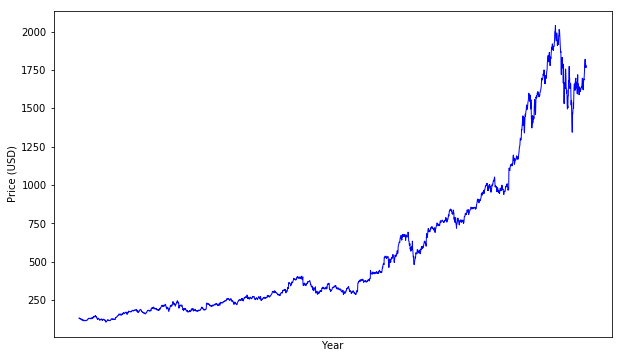

In [24]:
# Lets confirm the data works the same as above
print('We have access to the following data:')
for col in historical_data['Amazon.com Inc.'].columns.values:
    print('\t',col)


# Lets go ahead and take a look at Amazon's historical closing price
print('\n\nHistorical Closing Price for Amazon Stock:')
fig, ax = plt.subplots(1,1,figsize=(10,6))
ax.plot_date(historical_data['Amazon.com Inc.'].index.values, historical_data['Amazon.com Inc.']['Close'],
             color='blue',linewidth=1,marker='',linestyle='-')

#print dates.YearLocator()
ax.xaxis.set_major_locator(dates.YearLocator(base=5))
ax.set_xlabel('Year')
ax.set_ylabel('Price (USD)')
plt.show()
plt.close()

## Generate VWAP and SMAP Data
Naturally, we can still use the VWAP and SMAP functions we created above. Lets go ahead and generate the data using an anchor of 15 days and the stock closing price exactly as before but now with the S&P 500 set of stocks.

In [5]:
import metrics

lookback = 15
for company in historical_data:
    historical_data[company]['VWAP'] = metrics.calc_vwap(historical_data[company]['Close'],historical_data[company]['Volume'],lookback)
    historical_data[company]['SMAP'] = metrics.calc_smap(historical_data[company]['Close'],lookback)

/home/hofbr/GitProjects/VWAP_backtest/metrics.py:9: RuntimeWarning: invalid value encountered in double_scalars
  vwap[i] = (price[lb:ub] * volume[lb:ub]).sum() / volume[lb:ub].sum()


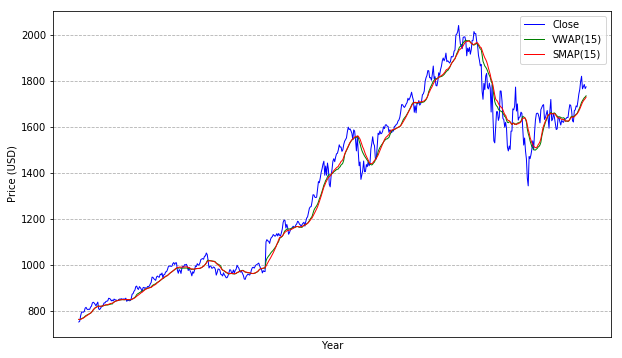

In [26]:
# Lets go ahead and take a look at the amazon data from 2017 on
start = '2017-01-01'
fig, ax2 = plt.subplots(1,1,figsize=(10,6))

ax2.plot_date(historical_data['Amazon.com Inc.'][start:].index.values, historical_data['Amazon.com Inc.'][start::]['Close'],
             color='blue',linewidth=1,marker='',linestyle='-',label='Close')
ax2.plot_date(historical_data['Amazon.com Inc.'][start:].index.values, historical_data['Amazon.com Inc.'][start::]['VWAP'],
             color='green',linewidth=1,marker='',linestyle='-',label='VWAP('+str(lookback)+')')
ax2.plot_date(historical_data['Amazon.com Inc.'][start:].index.values, historical_data['Amazon.com Inc.'][start::]['SMAP'],
             color='red',linewidth=1,marker='',linestyle='-',label='SMAP('+str(lookback)+')')

ax2.xaxis.set_major_locator(dates.MonthLocator(interval=2))
ax2.xaxis.set_major_formatter(dates.DateFormatter("%b '%y"))
ax2.set_xlabel('Year')
ax2.set_ylabel('Price (USD)')
ax2.legend()
ax2.grid(linestyle='dashed')
plt.show()
plt.close()

## Simple Strategy Repeated

We are going to implement the same strategy above on the S&P 500. Once again, we'll stick to the following principles:

1. When the price is above the SMAP or the VWAP, we are going to be in a long position.
2. When the price is below the SMAP or the VWAP, we are going to be in a cash position.

In [27]:
# first get data in a new data frame for all stocks since 2010
start = '2010-01-01'
modern_data = {}
for company in historical_data:
    modern_data[company] = historical_data[company].copy().loc[start::]
    # note that the lookback time should be the same as the lookback used to calulate the SMAP and VWAP
    modern_data[company]['SMAP_Signal'] = set_signal(modern_data[company]['SMAP'], modern_data[company]['Close'], lookback)
    modern_data[company]['VWAP_Signal'] = set_signal(modern_data[company]['VWAP'], modern_data[company]['Close'], lookback)
    modern_data[company]['SMAP_Value']  = set_value (modern_data[company]['SMAP_Signal'], modern_data[company]['Open'])
    modern_data[company]['VWAP_Value']  = set_value (modern_data[company]['VWAP_Signal'], modern_data[company]['Open'])
    
    # also calculate the benchmark signal and value
    bm_signal = np.ones(len(modern_data[company]['Open']))
    bm_signal[0:15] = 0 # we don't want a headstart on the benchmark...
    modern_data[company]['BM_Signal'] = bm_signal
    modern_data[company]['BM_Value']  = set_value (modern_data[company]['BM_Signal'], modern_data[company]['Open'])
    
# and lets go ahead and take a look at Amazon
modern_data['Amazon.com Inc.'].tail(1)

,High,Low,Open,Close,Volume,Adj Close,VWAP,SMAP,SMAP_Signal,VWAP_Signal,SMAP_Value,VWAP_Value,BM_Signal,BM_Value
Date,,,,,,,,,,,,,,
2019-03-28,1777.930054,1753.469971,1770.0,1773.420044,3043000,1773.420044,1734.289814,1728.893753,1.0,1.0,4.381888,3.445992,1.0,14.681487


## Initial visualization

Here, we once again plot the VWAP vs SMAP. We also plot the diagonal. Points above the diagonal mean that the VWAP outperformed the SMAP and points below the diagonal mean that the VWAP underperformed the SMAP. For the most part, we see that the points lie close to the diagonal, indicating that the strategies perform similarly.

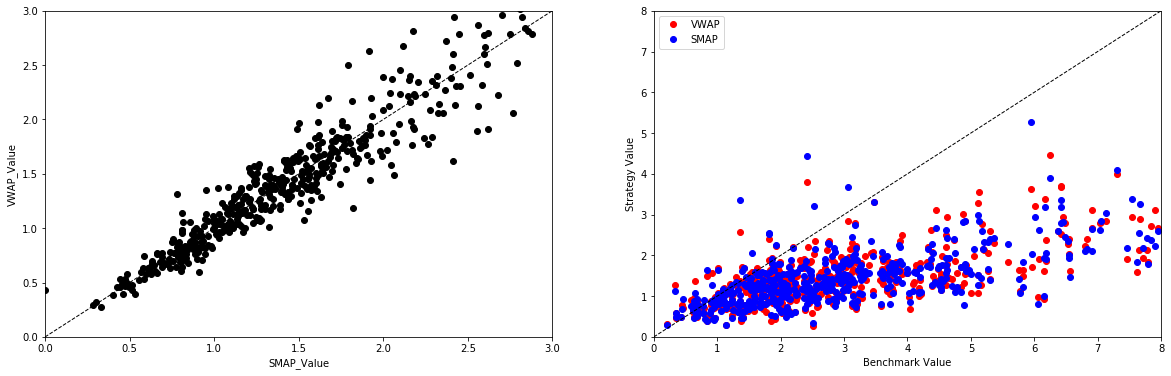

In [28]:
# First, lets get the relevant data
smaps = []
vwaps = []
bms   = []
for company in modern_data:
    smaps.append(modern_data[company].iloc[-1]['SMAP_Value'])
    vwaps.append(modern_data[company].iloc[-1]['VWAP_Value'])
    bms.append(modern_data[company].iloc[-1]['BM_Value'])

smaps = np.array(smaps)
vwaps = np.array(vwaps)
bms   = np.array(bms)
    
# Make the plot of SMAP vs VWAP
fig, ax = plt.subplots(1,2,figsize=(20,6))
ax[0].plot(smaps,vwaps,marker='o',linestyle='', color = 'black')
ax[0].plot([0,100],[0,100],linestyle='--',linewidth=1, color = 'black')
ax[0].set_xlabel('SMAP_Value')
ax[0].set_ylabel('VWAP_Value')
ax[0].set_xlim([0,3])
ax[0].set_ylim([0,3])


ax[1].plot(bms,vwaps,marker='o',linestyle='', color = 'red',label='VWAP')
ax[1].plot(bms,smaps,marker='o',linestyle='', color = 'blue',label='SMAP')
ax[1].plot([0,100],[0,100],linestyle='--',linewidth=1, color = 'black')
ax[1].set_xlabel('Benchmark Value')
ax[1].set_ylabel('Strategy Value')
ax[1].legend()
ax[1].set_xlim([0,8])
ax[1].set_ylim([0,8])

# Also plot SMAP and VWAP versus the benchmark
plt.show()

Lets again take a look at the average relative return and the standard deviation of VWAP to SMAP and lets plot the distribution to see if it looks normal.

The average return of the vwap strategy relative to the smap strategy is -0.004844 with standard deviation 0.2956


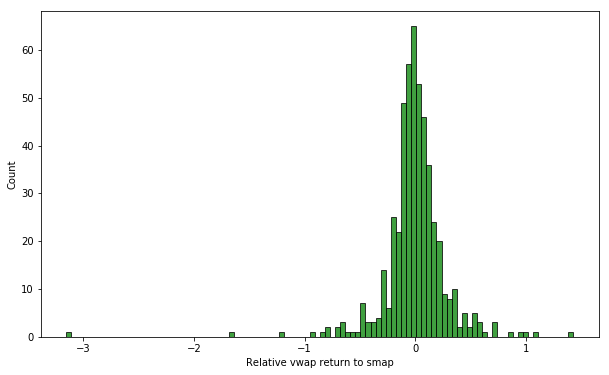

In [29]:
delta          = vwaps - smaps
vwap_smap_mean = delta.mean()
vwap_smap_std  = delta.std()

print("The average return of the vwap strategy relative to the smap strategy is {:.4} \
with standard deviation {:.4}".format(vwap_smap_mean, vwap_smap_std))

fig, ax = plt.subplots(1,1,figsize=(10,6))
ax.hist(delta, 100, facecolor = 'green', alpha=0.75,edgecolor='black')
ax.set_xlabel('Relative vwap return to smap')
ax.set_ylabel('Count')
plt.show()

The VWAP average return is slightly less than the smap in average and the relative return is normally distributed around the mean.

This is even more clear if we confirm with the Gaussian function and the Pearson's chi-squared test

We can use the Gaussian function where for arbitrary real constants a, b and non zero c. The parameter a is the height of the curve's peak, b is the position of the center of the peak and c, the standard deviation, controls the width of the "bell". 

$$\mathrm{f(x)} = ae\times-\frac{(x-b)^2}{2c^2}$$

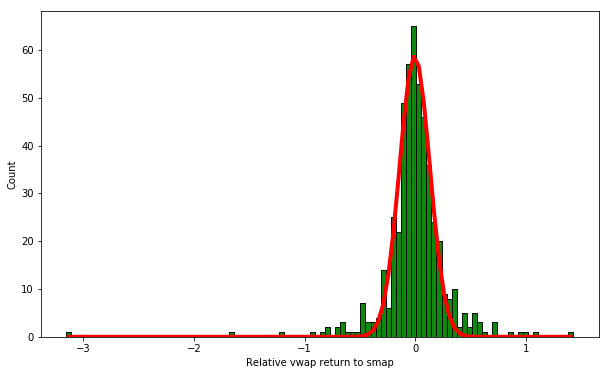

In [30]:
fig, ax = plt.subplots(1,1,figsize=(10,6))
ax.hist(delta, 100, facecolor = 'green', alpha=0.75,edgecolor='black')
ax.set_xlabel('Relative vwap return to smap')
ax.set_ylabel('Count')

import pylab as py
from scipy import optimize
from pylab import plot,show,hist

# Generate a 
y = delta
data = ax.hist(delta, 100, facecolor = 'green', alpha=0.75,edgecolor='black')

# Equation for Gaussian
def f(x, a, b, c):
    return a * py.exp(-(x - b)**2.0 / (2 * c**2))

# Generate data from bins as a set of points 
x = [0.5 * (data[1][i] + data[1][i+1]) for i in range(len(data[1])-1)]
y = data[0]

popt, pcov = optimize.curve_fit(f, x, y)

x_fit = py.linspace(x[0], x[-1], 100)
y_fit = f(x_fit, *popt)



plot(x_fit, y_fit, lw=4, color="r")

plt.show()


The Gaussian function demonstrates the normal distribution of the data visually and we can use Pearson's chi-squared test to represent this quantiatively.

In [31]:
from scipy.stats import chisquare
statistic = chisquare(vwaps, smaps)[0]
pvalue = chisquare(vwaps, smaps)[1]

chisquare(vwaps, smaps)

print("In gneral the null hypothesis says that the two variables (vwap and smap) are independent. The p-value is {:.4} \
implying there is a very low chance that VWAP and SMAP are independent of each other".format(pvalue))



In gneral the null hypothesis says that the two variables (vwap and smap) are independent. The p-value is 1.393e-98 implying there is a very low chance that VWAP and SMAP are independent of each other


We want to see if this relationship changes at all as the look back is increased. Let's run our functions for the following look back scenarios [5, 10, 20, 40, 80, 160, 252] and see how the mean changes.